In [1]:
import sys
import os
utils_dir = '../../src/utils'
# sys.path.insert(0, utils_dir) # add utils dir to path
# import testbed_utils as tu
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
from scipy import stats
import seaborn as sns

In [5]:
def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def get_clib_log(data_dir, method, sample, conf, ep):
    clib_log_file = os.path.join(data_dir, method, '{}-{}'.format(sample, conf), '0_log_ep{}'.format(ep), 'usage.log')
    if os.path.exists(clib_log_file):
        clib_log = read_file(clib_log_file)
    else:
        print("file {} does not exist".format(clib_log_file))
    return clib_log

def get_vpp_perfmon(
    clib_log,
    nodes=['t0-dpdk-input', 't0-ip6-load-balance'],
    cols=['Counter', 'Count', 'Pkts', 'Counts/Pkts'],
    debug=False):
    perfmon = {node: {col: [] for col in cols} for node in nodes}
    node_id = 0
    i = 0
    while i < len(clib_log):
        l = clib_log[i].split()
        if nodes[node_id] in l:
            if debug:
                print('found node {}'.format(nodes[node_id]))
            l = l[1:]
            while len(l) == 4:
                # enter the loop for a node
                for j, col in enumerate(cols):
                    perfmon[nodes[node_id]][col].append(l[j])
                i += 1
                l = clib_log[i].split()
            node_id += 1
            if node_id == len(nodes): break
        i += 1
        if debug and i%100 == 0:
            print("#line: {}".format(i))
    return perfmon

In [3]:
data_dir = '/opt/aquarius/data/results/unittest/wiki'
method = 'ecmp-microbench-all'
sample = 'hour0'
ep = 0
conf = 'unittest'

clib_log = get_clib_log(data_dir, method, sample, conf, ep)

In [28]:
node_mapper = {
    't0-dpdk-input': 'DPDK',
    't0-ip6-load-balance': 'Aquarius'
}
df_perfmon_dict = {
    col: [] for col in ['Counter', 'Count', 'Pkts', 'Counts/Pkts', 'Node']
}
method = 'ecmp-microbench-all'
for sample in ['hour0']:
    for ep in [0]:
        clib_log = get_clib_log(data_dir, method, sample, conf, ep)
        perfmon = get_vpp_perfmon(clib_log)
        for node, v in perfmon.items(): # node, metrics
            v_len = len(v['Counter'])
            for k, vv in v.items(): # metric, values
                df_perfmon_dict[k] += vv
            df_perfmon_dict['Node'] += ['{}'.format(node_mapper[node])]*v_len
for col in ['Count', 'Pkts', 'Counts/Pkts']:
    df_perfmon_dict[col] = np.array(df_perfmon_dict[col]).astype(float)
df_perfmon = pd.DataFrame.from_dict(df_perfmon_dict)

Text(0.5, 0, 'Node')

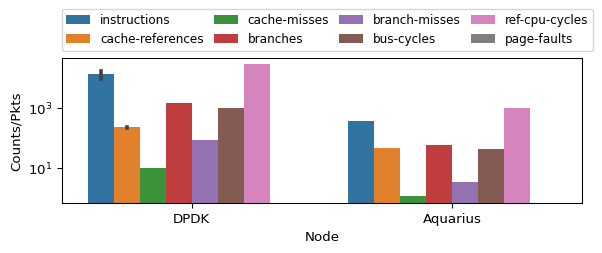

In [30]:
fig = plt.figure(figsize=(7,2), dpi=96)
# r = range(len(methods))
g = sns.barplot(x="Node", y="Counts/Pkts", hue='Counter',
                  data=df_perfmon.loc[
                                      (df_perfmon['Pkts'].values.astype('int')>=5000)]
               )
g.legend_.set_title(None)

plt.legend(bbox_to_anchor=(0., 1.05, 1.02, .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0., fontsize=9)

# plt.yticks(r, [METHOD_MAPPER[m] for m in methods], rotation=0)
plt.yscale('log')

plt.xlabel('Node')
# fig.savefig(os.path.join('../../data/figures/atc', 'sys-perf.pdf'), bbox_inches='tight', transparent=True)

In [7]:
def clip_outliers(X):
    X = np.array(X)
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    # X is the 1D data array
    z_scores = stats.zscore(X)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return X[filtered_entries]

def load_shm(filename, as_range, as_split_by):
    global FEATURE_AS_ALL, GT
    min_max_scale = lambda x: (x - x.min()) / (x.max() - x.min())
    normalize = lambda x: (x - x.mean())/x.std()
    lines = read_file(filename)
    lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
    df_dict = {
        'asid': [],
        '#cpu': [],
    }
    df_dict.update({k: [] for k in FEATURE_AS_ALL})
    df_dict.update({k: [] for k in GT})
    for l in lines:
        d = json.loads(l)
        for as_id in as_range:
            for i, k in enumerate(FEATURE_AS_ALL):
                df_dict[k].append(d['feature_as'][as_id][i])
            for i, k in enumerate(GT):
                df_dict[k].append(d['gt'][as_id][i])
            if df_dict['asid'][-1] < as_split_by: ncpu = 1
            else: ncpu = 2
            df_dict['#cpu'].append(ncpu)
    for k, v in df_dict.items():
        if k in ['asid', '#cpu']: continue
#         df_dict[k] = normalize(np.array(v))
#         df_dict[k] = min_max_scale(np.array(v))
    df_dict['cpu usage'] = df_dict['cpu']
    df_dict['#thread'] = df_dict['apache']
    del(df_dict['cpu'])
    del(df_dict['apache'])
    return pd.DataFrame.from_dict(df_dict)

In [14]:
'''
read data from json file
'''
def json_read_file(filename):
    with open(filename, "r") as read_file:
        return json.load(read_file)


shm_layout = json_read_file("../../src/lb/dev/shm_layout_base.json")

feature_as_cnt = [_[1] for _ in shm_layout["vpp"]["struct"]["as_stat"][1:]] # counter features gathered for each AS in as_stat_t
feature_as_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_as"]] # features gathered for each AS w/ reservoir sampling
feature_lb_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_lb"]] # features gathered for LB node w/ reservoir sampling
RES_FEATURE_ENG = ["avg", "90", "std", "avg_decay", "90_decay"]
FEATURE_AS_ALL = feature_as_cnt + ["_".join((a, b)) for a in feature_as_res for b in RES_FEATURE_ENG]
# avg AS features and append LB features
FEATURE_LB_ALL = FEATURE_AS_ALL + \
    ["_".join((a, b)) for a in feature_lb_res for b in RES_FEATURE_ENG]
GT = ["cpu", "memory", "apache", "asid"]

In [16]:
dfs = []
server_range = range(1, 7)
server_split_by = 4
for rate, hour in zip([477785/600], [0]):
    print("== process | Wiki | rate={} |".format(rate))
    trace = '{}-{}'.format(sample, conf)
    filename = "{}/{}/{}/0_log_ep{}/shm.json".format(data_dir, method, trace, ep)
    df = load_shm(filename, server_range, server_split_by)
    dfs.append(df)
    dfs[-1]['Traffic Rate'] = rate
    dfs[-1]['Trace'] = 'Wiki'

== process | Wiki | rate=796.3083333333333 |


In [17]:
def get_df_orig():
    global dfs
    df_all = pd.concat(dfs)
    df_all = df_all.fillna(0)
#     df_all = df_all.loc[df_all['memory']>0]
    return df_all

In [18]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def plot_heatmap(trace, filename=None):
    print("plot for trace {}".format(trace))
    df_ = df_all.loc[df_all['Trace'] == trace]
    trace_rate = df_['Traffic Rate'].unique()

    fig, axs = plt.subplots(len(trace_rate), figsize=(20, 2*len(trace_rate)), dpi=96)
    plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.2,   # the amount of width reserved for blank space between subplots
    hspace = 0.3,   # the amount of height reserved for white space between subplots
    )

    for i, rate in enumerate(trace_rate):
        if len(trace_rate) > 1:
            plt.sca(axs[i])
        ax = sns.heatmap(df_.loc[df_['Traffic Rate'] == rate].corr().iloc[[i for i, v in enumerate(cols_all) if v in row2plot], [i for i, v in enumerate(cols_all) if v in col2plot]], vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f", annot_kws={'rotation': 90, "fontsize":10}, cbar=False)
        plt.yticks(rotation=30) 
        if i < len(trace_rate) - 1: axs[i].xaxis.set_visible(False)
        plt.title("Traffic Rate = {:d} queries/s".format(int(rate)), y=0.9)
        if i == 0:
            # plot colorbar
            ax_divider = make_axes_locatable(ax)
            # define size and padding of axes for colorbar
            cax = ax_divider.append_axes('top', size = '5%', pad = '25%')
            # make colorbar for heatmap. 
            cb = plt.colorbar(ax.get_children()[0], cax=cax, orientation = 'horizontal')
            cb.outline.set_visible(False)
            # locate colorbar ticks
            cax.xaxis.set_ticks_position('top')
    plt.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight', transparent=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  


In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

cols_all = list(df.columns)
col2plot = [col for col in cols_all if col not in ['cpu usage', 'memory', '#thread', 'asid', '#cpu', 'Traffic Rate', 'Trace']]
col2log = [col for col in cols_all if 'byte' in col or 'iat' in col]
row2plot = ['#cpu', 'cpu usage', '#thread']

def get_preprocess_data(scaler_type='minmax'):
    df_all = get_df_orig()
    outlier_excluded_idx = (np.nan_to_num(np.abs(stats.zscore(df_all[col2plot]))) < 3)
    df_all = df_all[outlier_excluded_idx.all(axis=1)]
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_all.loc[:, col2log] = np.log(np.array(df_all.loc[:, col2log]+1e-6))
    return df_all, scaler

In [22]:
df_all, scaler = get_preprocess_data(scaler_type='std')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


plot for trace Wiki


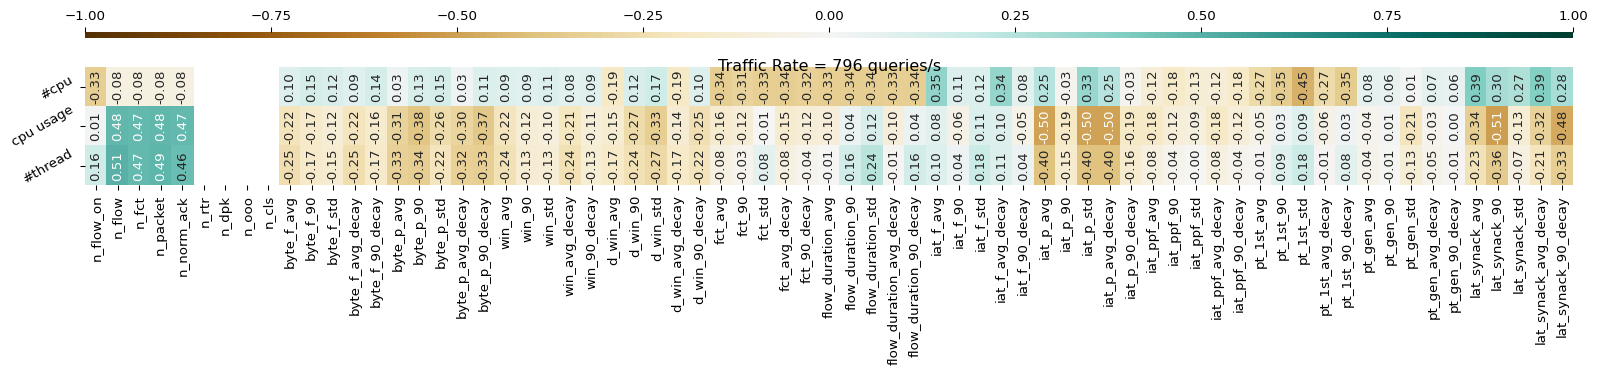

In [25]:


plot_heatmap('Wiki')